In [1]:
import pandas as pd

# Initialize an empty list to hold the chunks
dataframes = []

try:
    chunk_size = 10000  # Adjust based on your system's memory
    # Read the CSV file in chunks
    chunks = pd.read_csv("d1.csv", sep=',', low_memory=False, chunksize=chunk_size)
    
    # Iterate over the chunks and append them to the list
    for chunk in chunks:
        dataframes.append(chunk)
    
    # Concatenate all the chunks into a single DataFrame
    full_dataframe = pd.concat(dataframes, ignore_index=True)
    
    # Now you can work with full_dataframe
    print(full_dataframe.head())  # Display the first few rows

except pd.errors.ParserError as e:
    print(f"ParserError: {e}")
except Exception as e:
    print(f"An error occurred: {e}")


  Unnamed: 0                                              TWEET       STOCK  \
0        0.0  RT @robertoglezcano: @amazon  #Patents Show Fl...         NaN   
1        NaN                                             Amazon  31/01/2017   
2        1.0  @FAME95FM1 Jamaicans make money with @Payoneer...      PayPal   
3        2.0  @CBSi Jamaicans make money with @Payoneer @Pay...      PayPal   
4        3.0  @Hitz92fm Jamaicans make money with @Payoneer ...      PayPal   

         DATE  LAST_PRICE  1_DAY_RETURN  2_DAY_RETURN  3_DAY_RETURN  \
0         NaN         NaN           NaN           NaN           NaN   
1      823.48    0.008379      0.014924      0.014924     -0.001263   
2  31/01/2017   39.780000      0.002011      0.012318      0.012318   
3  31/01/2017   39.780000      0.002011      0.012318      0.012318   
4  31/01/2017   39.780000      0.002011      0.012318      0.012318   

   7_DAY_RETURN    PX_VOLUME  VOLATILITY_10D  VOLATILITY_30D LSTM_POLARITY  \
0           NaN     

In [2]:
full_dataframe = full_dataframe.dropna()

In [3]:
full_dataframe['LSTM_POLARITY'] = full_dataframe['LSTM_POLARITY'].replace({'-1': -1, '-1.0': -1, '1': 1, '1.0': 1})
polarity_summary = full_dataframe['LSTM_POLARITY'].value_counts()
print(full_dataframe['LSTM_POLARITY'].unique())

[-1.  1.]


C:\Users\HP\AppData\Local\Temp\ipykernel_6220\451382246.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  full_dataframe['LSTM_POLARITY'] = full_dataframe['LSTM_POLARITY'].replace({'-1': -1, '-1.0': -1, '1': 1, '1.0': 1})


In [4]:
stock_summary = full_dataframe['STOCK'].value_counts()

# Display the summary
print(stock_summary)

STOCK
Nike               3797
Reuters            2482
Apple              2238
eBay               2063
Netflix            1942
                   ... 
Danone                5
21CF                  4
Vodafone              4
Carrefour             2
Cardinal Health       2
Name: count, Length: 100, dtype: int64


In [5]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler  # Import StandardScaler for normalization

# Assuming full_dataframe is already loaded with your dataset

X = full_dataframe['TWEET']
y_columns = ['1_DAY_RETURN', '2_DAY_RETURN', '3_DAY_RETURN', '7_DAY_RETURN']

# Step 1: Initialize the scaler
scaler = StandardScaler()

# Step 2: Apply TF-IDF Vectorization
tfidf_vectorizer = TfidfVectorizer(max_features=5000)  # Limit to 5000 features
X_tfidf = tfidf_vectorizer.fit_transform(X)

# Initialize a dictionary to hold the models and their predictions
models = {}
predictions = {}

# Step 3: Train a separate Random Forest Regressor for each return column
for col in y_columns:
    y = full_dataframe[col].values.reshape(-1, 1)  # Reshape y for scaling
    
    # Normalize the target variable using StandardScaler
    y_scaled = scaler.fit_transform(y).ravel()  # Fit and transform, then flatten to a 1D array

    # Split the data into training and testing sets for each return
    X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y_scaled, test_size=0.2, random_state=42)

    # Train Random Forest Regression Model
    rf_regressor = RandomForestRegressor(n_estimators=100, random_state=42)
    rf_regressor.fit(X_train, y_train)
    
    # Make predictions
    y_pred = rf_regressor.predict(X_test)
    predictions[col] = y_pred
    
    # Evaluate the model using MSE on the scaled target
    mse = mean_squared_error(y_test, y_pred)
    models[col] = {'model': rf_regressor, 'mse': mse}

# Step 4: Display results
for col, result in models.items():
    print(f"Mean Squared Error for {col}: {result['mse']:.4f}")


Mean Squared Error for 1_DAY_RETURN: 0.7335
Mean Squared Error for 2_DAY_RETURN: 0.6663
Mean Squared Error for 3_DAY_RETURN: 0.6403
Mean Squared Error for 7_DAY_RETURN: 0.6115


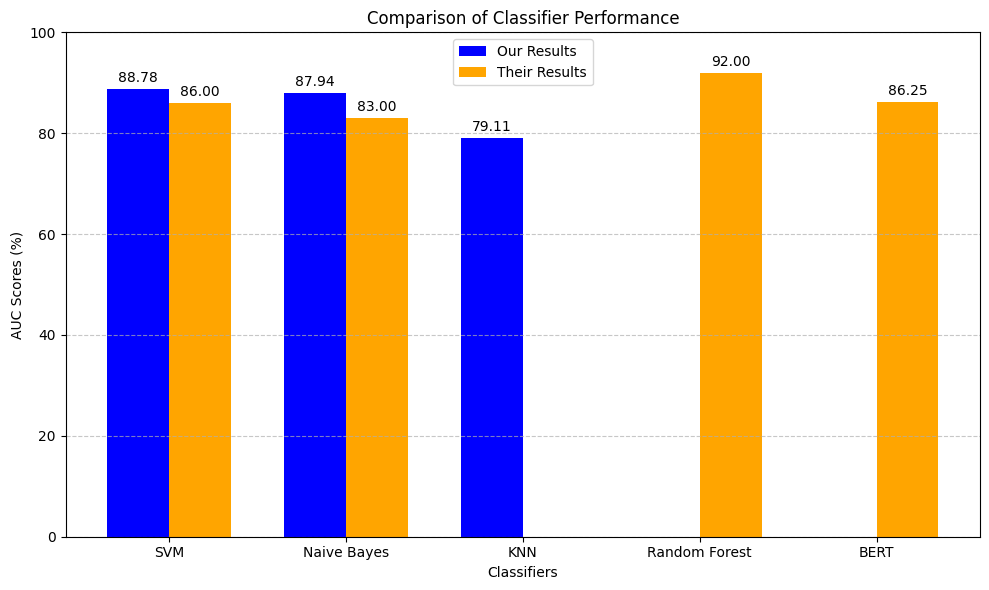

In [4]:
import matplotlib.pyplot as plt
import numpy as np

# Classifier names
classifiers = ['SVM', 'Naive Bayes', 'KNN', 'Random Forest', 'BERT']

# Our results (AUC scores for SVM, Naive Bayes, KNN)
our_results = [88.781, 87.940, 79.111, 0.0, 0.0]  # Set Random Forest and BERT as 0.0 for our results

# Results from Saxena et al. and Soni et al.
their_results = [86.0, 83.0, 0.0, 92.0, 86.25]  # Set KNN as 0.0 for their results

# Create bar positions
x = np.arange(len(classifiers))

# Set bar width
width = 0.35  

# Create the plot
fig, ax = plt.subplots(figsize=(10, 6))
bars1 = ax.bar(x - width/2, our_results, width, label='Our Results', color='blue')
bars2 = ax.bar(x + width/2, their_results, width, label='Their Results', color='orange')

# Add some text for labels, title, and custom x-axis tick labels, etc.
ax.set_xlabel('Classifiers')
ax.set_ylabel('AUC Scores (%)')
ax.set_title('Comparison of Classifier Performance')
ax.set_xticks(x)
ax.set_xticklabels(classifiers)
ax.legend()

# Add value annotations on top of bars
def add_value_labels(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}' if height > 0 else '',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

add_value_labels(bars1)
add_value_labels(bars2)

# Show the plot
plt.ylim(0, 100)  # Set limit for better visibility
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()
